In [1]:
import pandas as pd
import numpy as np
import gensim
import nltk
import json

import scipy
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from summa import summarizer
from many_stop_words import get_stop_words

/home/gzhigalov/miniconda3/envs/testing/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [53]:
df = pd.read_csv("DATASET.csv.gz", compression="gzip")

In [54]:
df.head()

,labels,lemmas,name,source,text,cc_article_number,civ_c_article_number,cc_section_number,cc_chapter_number
0,NaN,школа злословие учить прикусывать язык сохраня...,00021 Школа злословия,opencorpora,«Школа злословия» учит прикусить язык Сохранит...,NaN,NaN,NaN,NaN
1,NaN,последний восстание сеул международный биеннал...,00022 Последнее восстание в Сеуле,opencorpora,«Последнее восстание» в Сеуле Международная би...,NaN,NaN,NaN,NaN
2,NaN,отвечать дэвид лисс популярный автор историчес...,00023 За кота - ответишь!,opencorpora,"За кота – ответишь! Дэвид Лисс, популярный авт...",NaN,NaN,NaN,NaN
3,NaN,быстротечный кинороман отечественный кинематог...,00024 Быстротечный кинороман,opencorpora,Быстротечный кинороман Отечественные кинематог...,NaN,NaN,NaN,NaN
4,NaN,холодный ванна возвращать сила гидротерапия сч...,00014 Холодная ванна возвращает силы,opencorpora,Холодная ванна возвращает силы Гидротерапия: с...,NaN,NaN,NaN,NaN


# fasttext

In this notebook we work only with articles from criminal code and criminal court orders.

In [4]:
ds = df[df['source'].isin(["criminal_code", "criminal_court_orders"])].copy().reset_index(drop=True)

In [5]:
# For tesing purposes
#ds = pd.concat([
#     ds[ds['source'] == 'criminal_code'].sample(10),
#     ds[ds['source'] == 'criminal_court_orders'].sample(10),
# ]).reset_index(drop=True)

## Summarization

Because many texts have many repeating or other useless information we can summarize all texts by `textrank` algorithm 

In [6]:
def summ_text(text, ratio=0.25, stopwords=get_stop_words("ru"), language="russian"):
    return summarizer.summarize(
        text, ratio=ratio, 
        language=language, 
        additional_stopwords=stopwords
    )

In [7]:
%%time
ds['summ'] = ds['text'].map(summ_text)

In [8]:
ds.to_csv("summ_data.csv.gz", compression="gzip", index=False)

In [9]:
ds = pd.read_csv("summ_data.csv.gz", compression="gzip")

Empty results replaces with text itself

In [10]:
ds['summ'] = ds.apply(lambda row: row['text'] if pd.isnull(row['summ']) else row['summ'], axis=1)

Remove \n, \r and multiple spaces from texts:

In [11]:
ds['summ'] = ds['summ'].str.split().map(lambda x: " ".join(x))

Split summarized texts on sentences. If sentence longer than `max_len` parameter, then split it to several chunks.

In [12]:
def split_sent(text, min_len=3, max_len=50):
    def split_text(text, max_words=50):
        words = text.split()
        return [" ".join(words[i:i + max_words]) for i in range(0, len(words), max_words)]
    
    res = []
    for sent in nltk.sent_tokenize(text):
        res += list(filter(lambda x: len(x.split()) > min_len, split_text(sent, max_len)))
    return res

In [13]:
res = []
for i, row in ds.iterrows():
    sents = split_sent(row['summ'])
    if sents:
        for sent in sents:
            res.append({
              "labels": row["labels"], 
              "name": row["name"],
              "cc_article_number": row["cc_article_number"],
              "cc_section_number": row["cc_section_number"],
              "cc_chapter_number": row["cc_chapter_number"],
              "source": row["source"],
              "sent": sent
            })

s = pd.DataFrame(res)

In [14]:
assert len(ds['cc_article_number'].unique()) == len(s["cc_article_number"].unique())

Simple wrapper class for gensim fasttext algorithm

In [15]:
import tempfile
import numpy as np
import gensim


class FastTextEmbedding:
    def __init__(self):
        pass

    def train(self, sentences: list, model_path=None, corpus_path=None, **kwargs):
        """Create fasttext model and save to `model_path` (or to tmpfile by default)"""

        def make_corpus():
            self.corpus_path = corpus_path
            if not self.corpus_path:
                _, self.corpus_path = tempfile.mkstemp()
            gensim.utils.save_as_line_sentence(sentences, self.corpus_path)
            print("created corpus at {}".format(self.corpus_path))
            return self.corpus_path

        self.model_path = model_path
        if not self.model_path:
            _, self.model_path = tempfile.mkstemp()

        print("start training")
        self.model = gensim.models.FastText(corpus_file=make_corpus(), **kwargs)
        print("training complete")
        print("saving model to {}".format(model_path))
        self.model.save(model_path)
        print("done")
        return self

    def sent_emb(self, sentence: str):
        """Returns mean embedding vector of all word embedding vectors in text"""

        def normalize(arr):
            return np.array(arr) / np.linalg.norm(arr)

        res = [
            normalize(self.model.wv[word])
            for word in sentence.split()
            if word in self.model.wv
        ]
        return np.mean(res, axis=0)

    def load_model(self, fname):
        self.model = gensim.models.FastText.load(fname)
        print("model loaded")
        return self

Long part with training

In [ ]:
ft_emb = FastTextEmbedding().train(
    sentences=s["sent"].str.split().tolist(),
    model_path="fasttext.model",
    corpus_path="fasttext.corpus",
    size=300,
    word_ngrams=1,
    iter=100,
)

start training
created corpus at fasttext.corpus


In [ ]:
FastTextEmbedding().load_model("fasttext.model")

In [ ]:
s['fasttext'] = s["sent"].map(ft_emb.sent_emb)

In [ ]:
s.head()

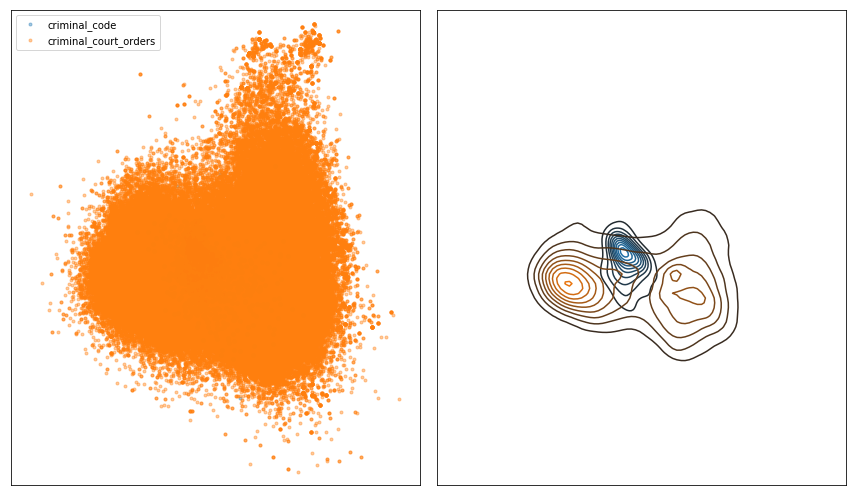

In [56]:
s['pca'] = PCA(2).fit_transform(s['fasttext'].tolist()).tolist()


METHOD = 'pca'
DISPLAY = s['source'].unique()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7), sharex='all', sharey='all')

for source in s['source'].unique():
    if source in DISPLAY:
        tmp = np.array(s[s['source'] == source][METHOD].tolist())
        ax1.scatter(tmp[:, 0], tmp[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, legend=False, shade_lowest=False)
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()

plt.savefig("ft_pca.png")

plt.show()

In [57]:
cc = (
    s[s["source"] == "criminal_code"]
    .groupby("name")
    .agg({
        "sent": list, 
        "source": "first", 
        "fasttext": list,
        "cc_article_number": "first",
        "cc_section_number": "first",
        "cc_chapter_number": "first",
    }).reset_index(drop=False)
)
co = (
    s[s["source"] == "criminal_court_orders"]
    .groupby("name")
    .agg({"labels": "first", "sent": list, "source": "first", "fasttext": list})
    .reset_index(drop=False)
)

In [ ]:
cc.head()

## Constellation divergency
For measuring distance between texts in latent spaces we introduce new formula:

In example we have two texts $a$ and $b$ consists of sentences:  $a_1, a_2, ..., a_N$ и $b_1, b_2, ..., b_M$ embedded in some space.

We set some measure of distance between two sentences: $d_{i, j}$.

**Сonstellation divergency** of text $a$ to text $b$ is given by:

$$
\rho_{a, b} = \frac{1}{N}\sum^{N}_{i=1} \min_{j=1,...,M} d_{i, j}
$$



In [ ]:
def text_distance(text_a, text_b, sent_dist=scipy.spatial.distance.cosine):
    """Calculate distance between two embedded texts.
    params:
        text_a - first text
        text_b - second text
        sent_dist - function that takes two arguments - two vectors and calculate distance between them.
    """
    dist = np.zeros((len(text_a), len(text_b)))
    for i, sent_a in enumerate(text_a):
        for j, sent_b in enumerate(text_b):
            dist[i, j] = sent_dist(sent_a, sent_b)
    return dist.min(axis=1).sum() / len(text_a)

In [ ]:
# %%time 

# distances = np.zeros((cc.shape[0], co.shape[0]))

# for i, text_a in cc['fasttext'].iteritems():
#     for j, text_b in co['fasttext'].iteritems():
#         distances[i, j] = text_distance(text_a, text_b, )

In [ ]:
co_sample = co.sample(1000).copy()

In [ ]:
distances = np.zeros((co_sample.shape[0], cc.shape[0]))

for i, (_, text_a) in enumerate(co_sample['fasttext'].iteritems()):
    if i % 10 == 0:
        print( i, "rows processed")
    for j, text_b in cc['fasttext'].iteritems():
        distances[i, j] = text_distance(text_a, text_b, )

In [ ]:
plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(distances)
plt.savefig("ft_distances.png")

In [ ]:
tmp = np.array(np.unique(np.argpartition(distances, kth=5)[:, :5].flatten(), return_counts=True)).T
for x in np.array(sorted(tmp, key=lambda x: x[1], reverse=True))[:, 0][:5]:
    print(cc["name"].iloc[x])

In [ ]:
co_sample["labels"] = co_sample['labels'].map(lambda x: list(map(float, x.split())))

In [ ]:
# def averaged_accuracy(y_true, y_pred):
#     return len(set(y_true) & set(y_pred)) / len(set(y_true) | set(y_pred))

# def exact_accuracy(y_true, y_pred):
#     return 1 if set(y_true) == set(y_pred) else 0

def weak_accuracy(y_true, y_pred):
    return 1 if set(y_true) & set(y_pred) else 0

In [ ]:
results_ft = []

for N in range(cc.shape[0]):
    targets = []
    for i in range(co_sample.shape[0]):
        targets.append(cc.iloc[np.argpartition(distances, kth=N)[:, :N][i]]['cc_article_number'].tolist())

    co_sample['targets'] = targets
    weak_acc = co_sample.apply(lambda row: weak_accuracy(row["targets"], row["labels"]), axis=1).mean()
    
    results_ft.append((N, weak_acc))
results_ft = np.array(results_ft)

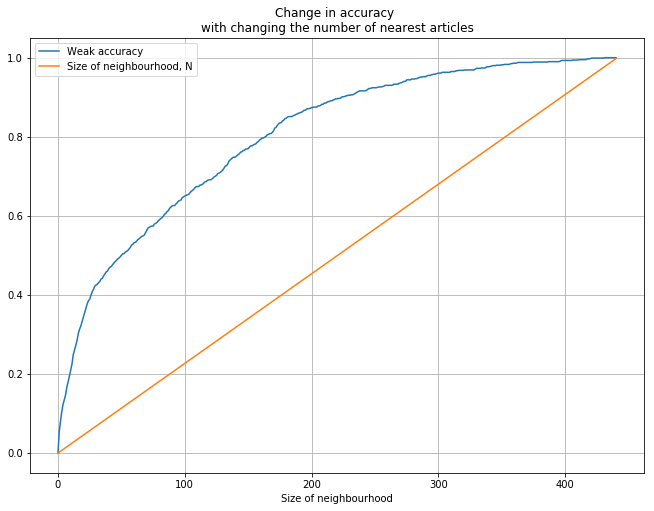

In [62]:
plt.figure(figsize=(11,8))
plt.plot(results_ft[:, 1], label="Weak accuracy")
plt.plot(results_ft[:, 0] / cc.shape[0], label="Size of neighbourhood, N")
plt.title("Change in accuracy \nwith changing the number of nearest articles")
plt.legend()
plt.xlabel("Size of neighbourhood")
plt.ylabel("")
plt.grid()
plt.savefig("ft_wa.png")
plt.show()

## Graph structure of criminal code

In [ ]:
import networkx as nx

In [58]:
dist_matrix = np.zeros((cc.shape[0], cc.shape[0]))

for i, text_a in cc['fasttext'].iteritems():
    for j, text_b in cc['fasttext'].iteritems():
        dist_matrix[i, j] = text_distance(text_a, text_b)

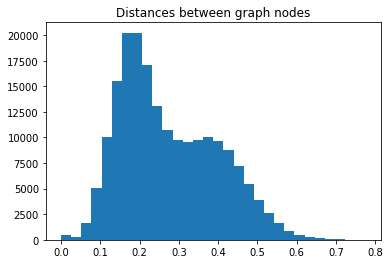

In [59]:
plt.hist(dist_matrix.flatten(), bins=30)
plt.title("Distances between graph nodes")
plt.savefig("ft_graph_hist.png")
plt.show()

In [60]:
graph = nx.from_pandas_adjacency(
    pd.DataFrame(
        dist_matrix, 
        index=cc['cc_article_number'], 
        columns=cc['cc_article_number']
    )
)

chapters = {p[0]:p[1] for p in zip(cc['cc_article_number'].tolist(), cc['cc_chapter_number'].tolist())}
sections = {p[0]:p[1] for p in zip(cc['cc_article_number'].tolist(), cc['cc_section_number'].tolist())}

nx.set_node_attributes(graph, chapters, name='chapter_number')
nx.set_node_attributes(graph, sections, name='section_number')

In [ ]:
nx.write_gexf(graph, 'fasttext_graph_full.gexf')

/home/gzhigalov/miniconda3/envs/testing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


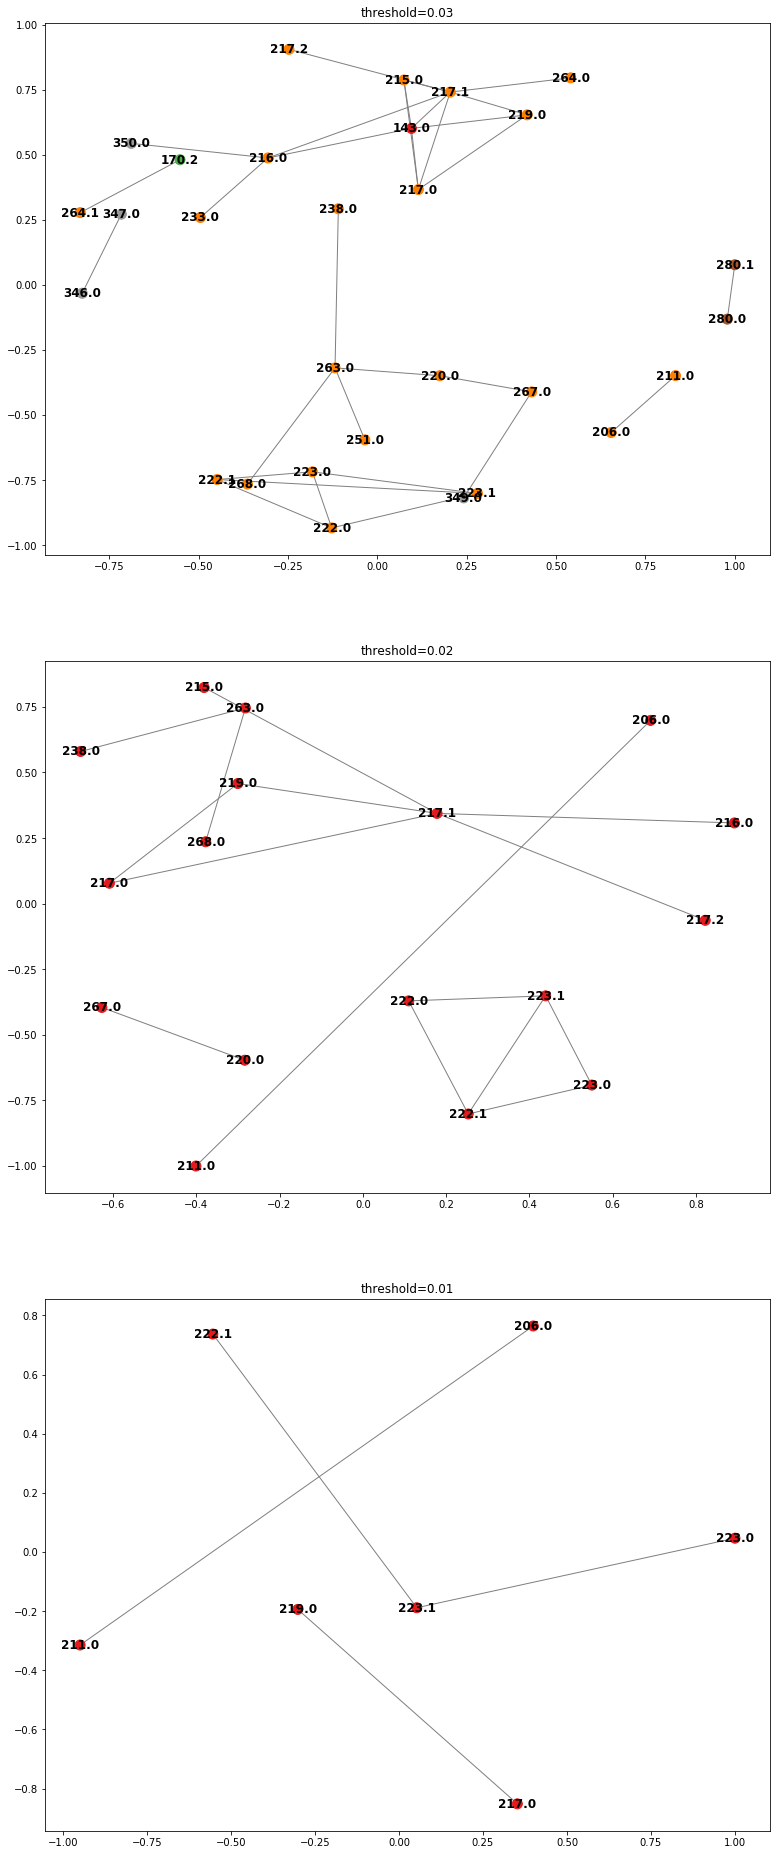

In [63]:
from matplotlib import cm

def plot_graph(threshold):
    def filter_matrix(m, t):
        return (m < t) * m
    
    graph = nx.from_pandas_adjacency(
        pd.DataFrame(
            filter_matrix(dist_matrix, threshold), 
            index=cc['cc_article_number'], 
            columns=cc['cc_article_number']
        )
    )
    deg = graph.degree()
    sub = graph.subgraph([n for n in graph.nodes if deg[n] != 0])
    colors=list(map(lambda x: cc[cc['cc_article_number'] == x]['cc_section_number'].values[0], sub.nodes))
    return nx.draw_networkx(sub, 
#         pos=nx.drawing.kamada_kawai_layout(sub),
                            pos=nx.spring_layout(sub),
                            font_color='black', 
                            font_size=12, 
                            font_weight='bold', 
                            edge_color='grey', 
                            node_size=100,
                            node_color=colors,
                            cmap=cm.Set1
                           )

t = [0.03, 0.02, 0.01]
fig = plt.figure(figsize=(13, 45))
for i, ti in enumerate(t):
    fig.add_subplot(4, 1, i+1)
    plt.title('threshold={}'.format(ti))
    plot_graph(ti)
plt.savefig("ft_graph.png")

# doc2vec

In [ ]:
import os
import tempfile
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import gensim


class doc2vecEmbedding:
    def __init__(self, model_path=None, phraser_path=None, corpus_path=None,
                 do_phrase=True, stopwords=None):
        
        self.model_path = model_path
        if not self.model_path:
            _, self.model_path = tempfile.mkstemp()

        self.corpus_path = corpus_path
        if not self.corpus_path:
            _, self.corpus_path = tempfile.mkstemp()  
    
        self.do_phrase = do_phrase
        if self.do_phrase:
            self.phraser_path = phraser_path
            if not phraser_path:
                _, self.phraser_path = tempfile.mkstemp()
        self.stemmer = Mystem(entire_input=False)
        self.stopwords = stopwords
        if not self.stopwords:
            self.stopwords = get_stop_words("ru")
    
    def lemmatize_and_filter(self, text, min_len=2):
        text = self.stemmer.lemmatize(text)
        return " ".join(list(filter(lambda word: word not in self.stopwords and len(word) > min_len, text)))
    
    def train(self, sentences: list, **kwargs):
        """Create doc2vec model, save it to `self.model_path` (or to tmpfile by default) and return doc vectors"""
        
        def train_phraser(sentences):
            phrases = gensim.models.phrases.Phrases(sentences=list(map(str.split, sentences)))
            self.phraser = gensim.models.phrases.Phraser(phrases)
            self.phraser.save(self.phraser_path)
            print("Phraser saved to {}".format(self.phraser_path))
        
        def make_corpus(sentences):
            gensim.utils.save_as_line_sentence(list(map(str.split, sentences)), self.corpus_path)
            print("Corpus saved to {}".format(self.corpus_path))
        
        print("Filtering and lemmatizing")
        sentences = list(map(self.lemmatize_and_filter, sentences))
        print("Done filtering and lemmatizing texts")
        if self.do_phrase:
            print("Training phraser model")
            train_phraser(sentences)
            print("Done training phraser model. Phrasing texts")
            sentences = list(map(lambda sent: " ".join(self.phraser[sent.split()]), sentences))
            print("Texts phrased")
                                        
        make_corpus(sentences)
        print("Training doc2vec model")
        self.model = gensim.models.doc2vec.Doc2Vec(corpus_file=self.corpus_path, **kwargs)
        self.model.save(self.model_path)
        print("Model saved to {}".format(self.model_path))
        print("Training complete")
        return self.model.docvecs.vectors_docs.tolist()

    def sent_emb(self, sentence: str):
        return self.model.infer_vector(sentence)
    
    def load_phraser(self):
        return gensim.models.phrases.Phraser.load(self.phraser_path)

    def load_model(self, model_path, do_phrase=True, phraser_path=None):
        self.do_phrase = do_phrase
        if self.do_phrase:
            assert phraser_path, "Please set correct phraser_path"
            self.phraser_path = phraser_path
            self.phraser = self.load_phraser()
            print("phraser_loaded")
        self.model_path = model_path
        self.model = gensim.models.doc2vec.Doc2Vec.load(self.model_path)
        print("model loaded")
        return self

In [ ]:
!mkdir doc2vec_model

In [ ]:
d2v = doc2vecEmbedding(
    model_path="doc2vec_model/doc2vec.model",
    phraser_path="doc2vec_model/phraser",
    corpus_path="doc2vec_model/corpus"
)

word_vectors = d2v.train(
    sentences=s['sent'],
    epochs=100, vector_size=300, workers=4
)

In [ ]:
s["doc2vec"] = word_vectors

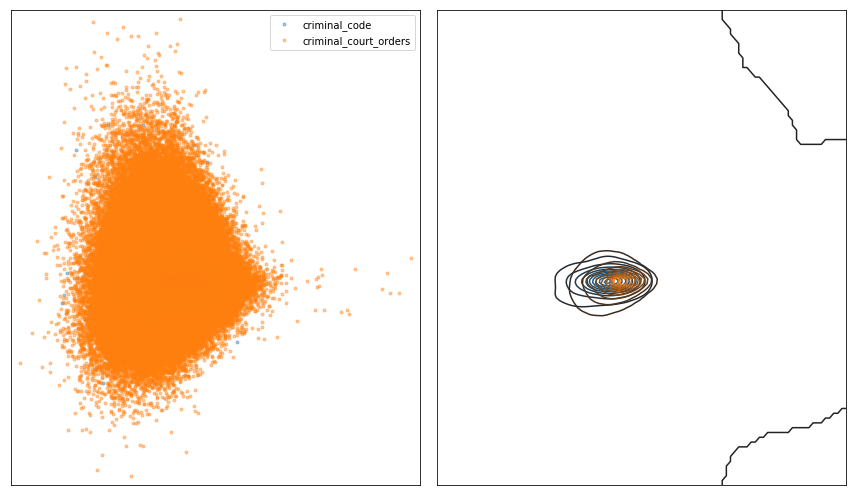

In [65]:
s['pca'] = PCA(2).fit_transform(s['doc2vec'].tolist()).tolist()


METHOD = 'pca'
DISPLAY = s['source'].unique()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7), sharex='all', sharey='all')

for source in s['source'].unique():
    if source in DISPLAY:
        tmp = np.array(s[s['source'] == source][METHOD].tolist())
        ax1.scatter(tmp[:, 0], tmp[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, legend=False, shade_lowest=False)
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()

plt.savefig("d2v_pca.png")

plt.show()

In [ ]:
cc = (
    s[s["source"] == "criminal_code"]
    .groupby("name")
    .agg({
        "sent": list, 
        "source": "first", 
        "doc2vec": list,
        "cc_article_number": "first",
        "cc_section_number": "first",
        "cc_chapter_number": "first",
    }).reset_index(drop=False)
)
co = (
    s[s["source"] == "criminal_court_orders"]
    .groupby("name")
    .agg({"labels": "first", "sent": list, "source": "first", "doc2vec": list})
    .reset_index(drop=False)
)

In [ ]:
co_sample = co.sample(1000).copy()

In [ ]:
distances = np.zeros((co_sample.shape[0], cc.shape[0]))

for i, (_, text_a) in enumerate(co_sample['doc2vec'].iteritems()):
    if i % 10 == 0:
        print( i, "rows processed")
    for j, text_b in cc['doc2vec'].iteritems():
        distances[i, j] = text_distance(text_a, text_b, )

In [ ]:
plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(distances)
plt.savefig("d2v_distances.png")

In [ ]:
tmp = np.array(np.unique(np.argpartition(distances, kth=5)[:, :5].flatten(), return_counts=True)).T
for x in np.array(sorted(tmp, key=lambda x: x[1], reverse=True))[:, 0][:5]:
    print(cc["name"].iloc[x])

In [ ]:
co_sample["labels"] = co_sample['labels'].map(lambda x: list(map(float, x.split())))

In [ ]:
results_d2v = []

for N in range(cc.shape[0]):
    targets = []
    for i in range(co_sample.shape[0]):
        targets.append(cc.iloc[np.argpartition(distances, kth=N)[:, :N][i]]['cc_article_number'].tolist())

    co_sample['targets'] = targets
    weak_acc = co_sample.apply(lambda row: weak_accuracy(row["targets"], row["labels"]), axis=1).mean()
    
    results_d2v.append((N, weak_acc))
results_d2v = np.array(results_d2v)

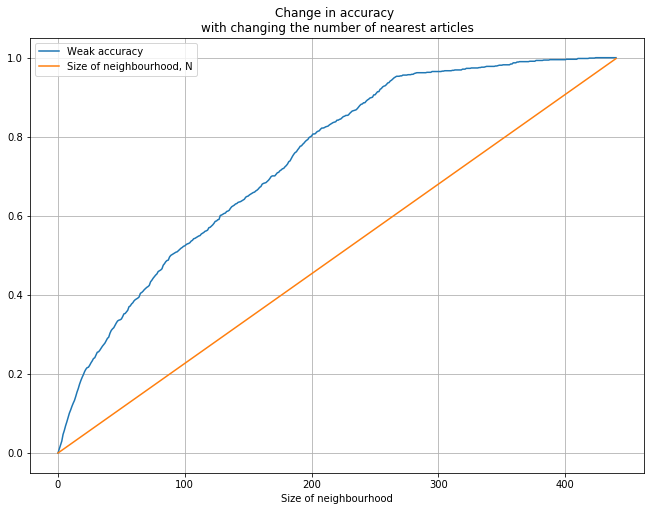

In [66]:
plt.figure(figsize=(11,8))
# plt.plot(results[:, 1], label="Accuracy")
# plt.plot(results[:, 2], label="Exact accuracy")
plt.plot(results_d2v[:, 1], label="Weak accuracy")
plt.plot(results_d2v[:, 0] / cc.shape[0], label="Size of neighbourhood, N")
plt.title("Change in accuracy \nwith changing the number of nearest articles")
plt.legend()
plt.xlabel("Size of neighbourhood")
plt.ylabel("")
plt.grid()

plt.savefig("d2v_wa.png")

plt.show()

## doc2vec vs. fasttext

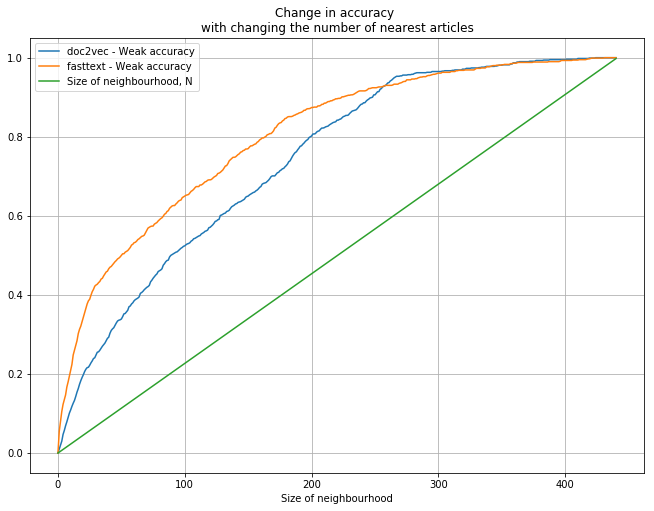

In [67]:
plt.figure(figsize=(11,8))
# plt.plot(results[:, 1], label="Accuracy")
# plt.plot(results[:, 2], label="Exact accuracy")
plt.plot(results_d2v[:, 1], label="doc2vec - Weak accuracy")
plt.plot(results_ft[:, 1], label="fasttext - Weak accuracy")
plt.plot(results_d2v[:, 0] / cc.shape[0], label="Size of neighbourhood, N")
plt.title("Change in accuracy \nwith changing the number of nearest articles")
plt.legend()
plt.xlabel("Size of neighbourhood")
plt.ylabel("")
plt.grid()

plt.savefig("ft_vs_d2v.png")

plt.show()